In [1]:
!pip install pgmpy
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.inference import VariableElimination
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve,confusion_matrix
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.0 MB/s eta 0:00:00


In [2]:
# Load Telco customer churn dataset
telco = pd.read_csv("/content/telecom_data.csv")

# Remove rows with missing values
telco = telco.dropna()

# Randomly select 8 variables
selected_vars = ["SeniorCitizen", "Partner", "Dependents", "PhoneService", 
                 "InternetService", "Contract", "PaperlessBilling", "PaymentMethod"]
telco = telco[selected_vars + ["Churn"]]

# Convert all variables to categorical type
for col in telco.columns:
    telco[col] = pd.Categorical(telco[col])

# Randomly split data into training and testing sets
train, test = train_test_split(telco, test_size=0.3, random_state=123)

# Create an empty Bayesian network structure
bn_model = BayesianNetwork()

In [3]:
# Specify the node labels and the structure of the Bayesian network
for var in selected_vars:
    bn_model.add_node(var)
bn_model.add_node("Churn")
bn_model.add_edges_from([(var, "Churn") for var in selected_vars])

# Train the Bayesian network using the training data
bn_model.fit(train, estimator=MaximumLikelihoodEstimator)

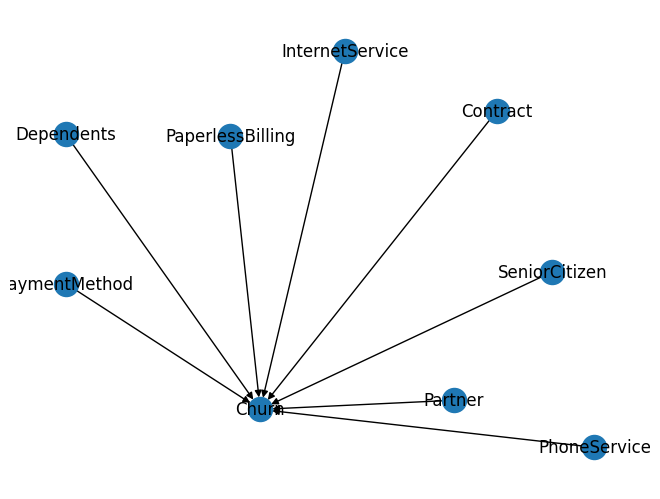

In [4]:
# Draw the Bayesian network
graph = nx.DiGraph(bn_model.edges())
nx.draw(graph, with_labels=True)
plt.show()

In [5]:
 

# Predict using the Bayesian network
infer = VariableElimination(bn_model)
test_prob_bn = []
for index, row in test.iterrows():
    q = infer.query(variables=["Churn"], evidence=row[selected_vars].to_dict())
    pred_prob = q.values[1]
    test_prob_bn.append(pred_prob)

# Evaluate the performance of the Bayesian model using AUC-ROC and accuracy
label_map = {"Yes": 1, "No": 0}
test["Churn"] = test["Churn"].map(label_map)
test_pred_bn = pd.Series(test_prob_bn, name="Churn")
test_pred_bn = test_pred_bn.map(lambda x: 1 if x > 0.5 else 0)

auc_bn = roc_auc_score(test["Churn"], test_prob_bn)
acc_bn = accuracy_score(test["Churn"], test_pred_bn)
print("Bayesian AUC-ROC:", auc_bn)
print("Bayesian Accuracy:", acc_bn)

Bayesian AUC-ROC: 0.7881150049523131
Bayesian Accuracy: 0.7614765735920492


In [6]:
# Convert categorical variables to one-hot encoding
train = pd.get_dummies(train, columns=selected_vars)
test = pd.get_dummies(test, columns=selected_vars)

train["Churn"] = train["Churn"].map(label_map)
# Create a list of all the feature columns
feature_cols = list(train.columns)
feature_cols.remove("Churn")

# Train a Random Forest Regression model using the training data
rf_model = RandomForestRegressor(random_state=123)
rf_model.fit(train[feature_cols], train["Churn"])

# Predict using the Random Forest Regression model
test_pred_rf = rf_model.predict(test[feature_cols])
test_pred_rf = pd.Series(test_pred_rf, name="Churn")

# Evaluate the performance of the Random Forest Regression model using AUC-ROC and accuracy
test_pred_rf = test_pred_rf.apply(lambda x: 1 if x > 0.5 else 0)
auc_rf = roc_auc_score(test["Churn"], test_pred_rf)
acc_rf = accuracy_score(test["Churn"], test_pred_rf)
print("Random Forest Regression AUC-ROC:", auc_rf)
print("Random Forest Regression Accuracy:", acc_rf)

Random Forest Regression AUC-ROC: 0.6704524967448279
Random Forest Regression Accuracy: 0.7576904874585897


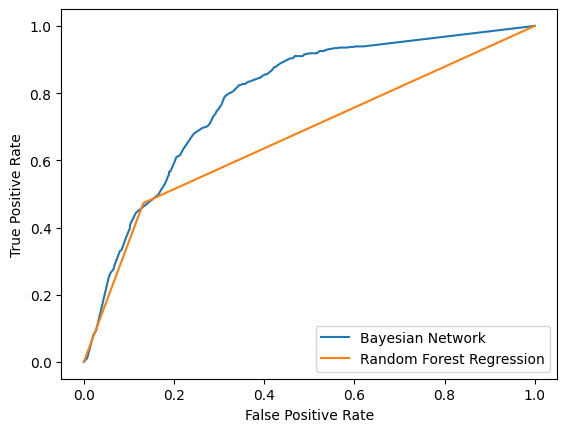

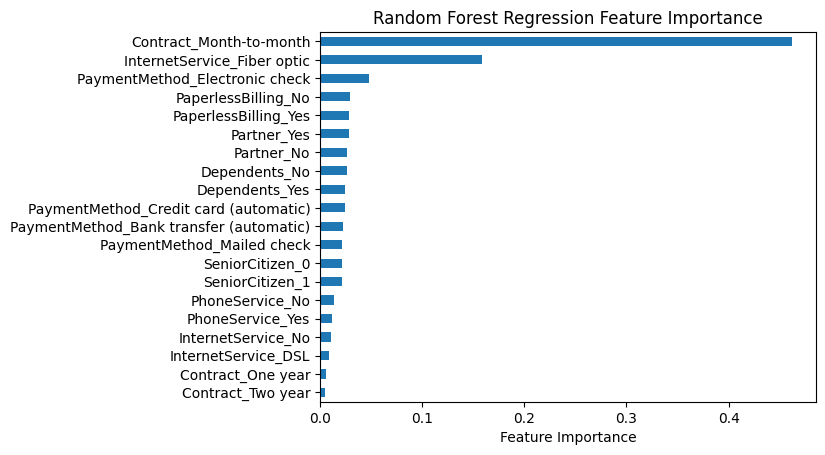

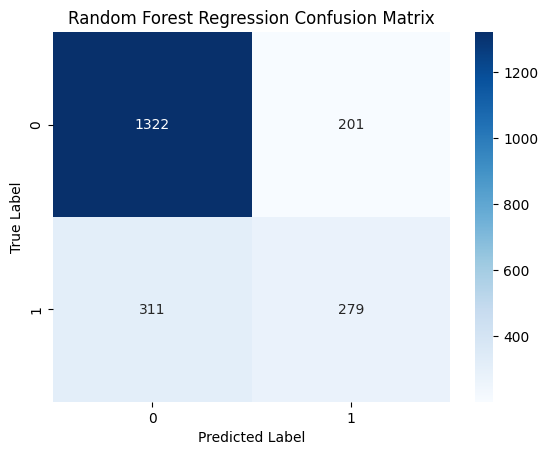

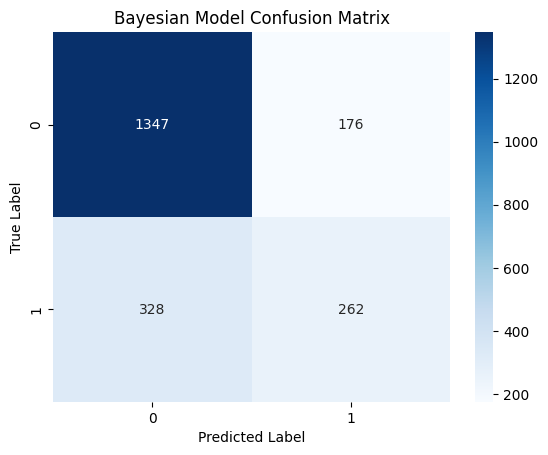

In [8]:
 # Compare the performance of the two models
fpr_bn, tpr_bn, _ = roc_curve(test["Churn"], test_prob_bn)
fpr_rf, tpr_rf, _ = roc_curve(test["Churn"], test_pred_rf)

plt.plot(fpr_bn, tpr_bn, label="Bayesian Network")
plt.plot(fpr_rf, tpr_rf, label="Random Forest Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Plot feature importance of the Random Forest Regression model
feat_importances = pd.Series(rf_model.feature_importances_, index=feature_cols)
feat_importances.sort_values().plot(kind="barh")
plt.xlabel("Feature Importance")
plt.title("Random Forest Regression Feature Importance")
plt.show()

# Plot the confusion matrix for the Random Forest Regression model
conf_mat = confusion_matrix(test["Churn"], test_pred_rf)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random Forest Regression Confusion Matrix")
plt.show()

# Get the confusion matrix for the Bayesian model
cm_bn = confusion_matrix(test["Churn"], test_pred_bn)

# Plot the confusion matrix using seaborn heatmap
sns.heatmap(cm_bn, annot=True, fmt="d", cmap="Blues")
plt.title("Bayesian Model Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
# Normalize the features
df.iloc[:, 1:] = (df - df.mean())/df.std()
# Create X, y and theta
X = df.iloc[:, 1:]
ones = np.ones([len(df), 1])
X = np.concatenate((ones, X), axis=1)
y = df.iloc[:, 0:1].values
theta = np.zeros([1, len_of_features + 1])
# Store target
target = y

# Display the size of the matrices
X.shape, y.shape, theta.shape
# Define computecost function
def computecost(X, y, theta):
    H = X @ theta.T
    J = np.power((H - y), 2)
    sum = np.sum(J)/(2 * len(X))
    return sum
  # Set iterations and alpha (learning rate)
alpha = 0.01
iterations = 500
# Define gradientdescent function
def gradientdescent(X, y, theta, iterations, alpha):
    cost = np.zeros(iterations)
    for i in range(iterations):
        H = X @ theta.T
        theta = theta - (alpha/len(X)) * np.sum(X * (H - y), axis=0)
        cost[i] = computecost(X, y, theta)
    return theta, cost

  # Do Gradient Descent and display final theta
final_theta, cost = gradientdescent(X, y, theta, iterations, alpha)
final_theta.round(2)
# Compute and display final cost
final_cost = computecost(X, y, final_theta)
final_cost.round(2)
# Plot Iterations vs. Cost figure
fig_2, ax = plt.subplots(figsize=(10, 8))
ax.plot(np.arange(iterations), cost, 'r')
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost')
ax.set_title('Iterations vs. Cost')
plt.show()
# Define rmse function
def rmse(target, final_theta):
    predictions = X @ final_theta.T
    return np.sqrt(((predictions[:, 0] - target[:, 0]) ** 2).mean())

# Compute and display Root Mean Squared Error
rmse_val = rmse(target, final_theta)
rmse_val.round(2)
# Display sample prediction for first observation
predictions = X @ final_theta.T
str(predictions[0].round(2))